In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import torch
from nn import MotifCaller, NaiveCaller
from training_data import data_preproc, load_training_data
from utils import get_savepaths
import numpy as np
from sklearn.preprocessing import normalize
from greedy_decoder import GreedyCTCDecoder
from Levenshtein import ratio
from utils import load_model, get_metrics_for_evaluation
from transcript_sorting import sort_transcript_reduced_spacers, sort_transcript
from sklearn.model_selection import train_test_split
from beam_search_decoder import beam_search_ctc, torch_ctc
import torch.nn as nn
from tqdm.notebook import tqdm
import numpy as np
#import matplotlib.pyplot as plt
from typing import List
from sklearn.preprocessing import normalize
from torch.nn.utils.rnn import pad_sequence
from beam_search_decoder import beam_search_ctc, torch_ctc
import matplotlib.pyplot as plt

### Loading models and data

In [3]:
n_classes = 19
model_path_forward = r"C:\Users\Parv\Doc\HelixWorks\Basecalling\code\motifcaller\models\empirical\final_models\latest_models\edit_forward.pth"
model_path_mixed = r"C:\Users\Parv\Doc\HelixWorks\Basecalling\code\motifcaller\models\empirical\final_models\latest_models\edit_mixed.pth"
model_path_reverse = r"C:\Users\Parv\Doc\HelixWorks\Basecalling\code\motifcaller\models\empirical\final_models\latest_models\edit_reverse.pth"

labels_int = np.arange(n_classes).tolist()
labels = [f"{i}" for i in labels_int] # Tokens to be fed into greedy decoder
greedy_decoder = GreedyCTCDecoder(labels = labels)
ctc = nn.CTCLoss(blank=0, reduction='mean', zero_infinity=True)

In [4]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.set_default_device(device)
model_forward = load_model(model_path=model_path_forward, device=device, n_classes=n_classes, hidden_size=256)
model_reverse = load_model(model_path=model_path_reverse, device=device, n_classes=n_classes, hidden_size=256)
model_mixed = load_model(model_path=model_path_mixed, device=device, n_classes=n_classes, hidden_size=256)

test_dataset_path = r"C:\Users\Parv\Doc\HelixWorks\Basecalling\code\motifcaller\data\empirical\full_datasets\diluted_squiggles.pkl"

#test_dataset_path = r"C:\Users\Parv\Doc\HelixWorks\Basecalling\code\motifcaller\data\empirical\sequencing_runs\01-04run\misc_datasets\small_squiggle_df.pkl"
#test_dataset_path = r"C:\Users\Parv\Doc\HelixWorks\Basecalling\code\motifcaller\data\empirical\sequencing_runs\01-04run\finetuning_datasets\edit_train.pkl"

dataset = pd.read_pickle(test_dataset_path)

In [ ]:
# For the new datasets
X, y = load_training_data(
        test_dataset_path, column_x='squiggle', column_y='payload', payload=False, orientation=False)

In [7]:
"""
X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42)

X_train, X_test, payloads_train, payloads_test = train_test_split(
        X, payloads, test_size=0.2, random_state=42)
"""

'\nX_train, X_test, y_train, y_test = train_test_split(\n        X, y, test_size=0.2, random_state=42)\n\nX_train, X_test, payloads_train, payloads_test = train_test_split(\n        X, payloads, test_size=0.2, random_state=42)\n'

In [6]:
def get_error_by_cycle_and_motif(preds, actual):
    cycles = np.zeros(8)
    motifs = np.zeros(8)

    
    for pred, act in zip(preds, actual):
        counter = 0
        for i, j in zip(pred, act):
            for k in i:
                if k not in j:
                    cycles[counter] += 1
                    motifs[k-1] += 1
            counter += 1

    return cycles / len(preds) * 100, motifs / len(preds) * 100

In [7]:
def evaluate_prediction(prediction, original):

    found = 0
    err = 0
    for i, j in zip(prediction, original):
        for k in range(len(i)):
            if i[k] in j:
                found += 1
            else:
                err += 1

    return found, err

In [8]:
def detect_reverse_oriented_read(transcript_reverse_model):

    # Remove payloads, make set, and check that each spacer motif is increasing
    no_payload_transcript = [
        int(i) for i in transcript_reverse_model if int(i) > 8]

    first_spacer = no_payload_transcript[0]
    flag = False
    for j in no_payload_transcript[1:]:
        if not j == first_spacer:
            if j < first_spacer:
                flag = True
            else:
                flag = False
            break
        
    return flag

    

In [9]:
def sort_and_evaluate_predictions(
        model_outputs_forward, labels, payload, model_outputs_reverse=None, model_outputs_mixed=None, orientation=None, beam=False, beam_width=10, prob_threshold=0.0):
    
    original = payload
    
    if beam:
        transcript_forward = torch_ctc(
            n_classes=19, model_output=model_outputs_forward.unsqueeze(0),
            beam_width=beam_width)
    else:
        result_forward, quality_forward = greedy_decoder.forward_with_quality(
            model_outputs_forward, prob_threshold=prob_threshold)
        transcript_forward = " ".join(result_forward)
    sorted_forward = sort_transcript(transcript_forward)
    
        
    if beam:
        transcript_reverse = torch_ctc(
            n_classes=19, model_output=model_outputs_reverse.unsqueeze(0),
            beam_width=beam_width)
    else:
        result_reverse, quality_reverse = greedy_decoder.forward_with_quality(
            model_outputs_reverse, prob_threshold=prob_threshold)
        transcript_reverse = " ".join(result_reverse)
    sorted_reverse = sort_transcript(transcript_reverse)

    actual_transcript = " ".join([str(i) for i in labels])
    sorted_actual = sort_transcript(actual_transcript)

    #motifs_found_search, motif_errs_search = evaluate_prediction(
    #    sorted_actual, original)

    motifs_found_search, motif_errs_search = [], []

    result_mixed = greedy_decoder.forward(model_outputs_mixed)
    
    motifs_found_caller_forward, motif_errs_caller_forward = evaluate_prediction(
        sorted_forward, original)
    
    if model_outputs_reverse is not None:
        motifs_found_caller_reverse, motif_errs_caller_reverse = evaluate_prediction(
            sorted_reverse, original)
        """
        if orientation is not None:
            if orientation == 1:
                return motifs_found_caller_forward, motif_errs_caller_forward, motifs_found_search, motif_errs_search, quality_forward, sorted_forward, 1
            else:
                return motifs_found_caller_reverse, motif_errs_caller_reverse, motifs_found_search, motif_errs_search, quality_reverse, sorted_reverse, 0
        """
        if detect_reverse_oriented_read(result_mixed):
            return motifs_found_caller_reverse, motif_errs_caller_reverse, motifs_found_search, motif_errs_search, quality_reverse, sorted_reverse, 0
        else:
            return motifs_found_caller_forward, motif_errs_caller_forward, motifs_found_search, motif_errs_search, quality_forward, sorted_forward, 1
        
    return motifs_found_caller_forward, motif_errs_caller_forward, motifs_found_search, motif_errs_search


### Batched evaluation loop

In [12]:
X_test = dataset['squiggle'].to_list()
#y_test = dataset['motif_seq'].to_list()
#edit_seq = dataset['edit_search_seq'].to_list()  # edit_search_seq
#read_ids_ = dataset['read_id'].to_list()
payloads_test = dataset['payload'].to_list()  # payload_seq
#orientations = dataset['orientation_x'].to_list()  # strand
#orientations = [1 if i.startswith('+') else 0 for i in orientations]

In [ ]:
payloads_test = dataset['payload'].apply(lambda x: list(eval(x)))

In [13]:
torch.set_default_device(device)

In [14]:

n_test_samples = len(X_test)
batch_size = 8
prob_threshold = 0.85


results_dict = {
    "mf_caller": [],
    "me_caller": [],
    "mf_search": [],
    "me_search": [],
    "mf_edit": [],
    "me_edit": [],
    "orientation": [],
    "quality": []
}
orientations_as_you_go = []

with torch.no_grad():
    for ind in tqdm(range(0, n_test_samples, batch_size)):

        if n_test_samples - ind < batch_size:
            continue
        
        input_seqs = [
            normalize([X_test[k]], norm='max').flatten() for k in range(ind, ind + batch_size)]
        
        input_seqs = pad_sequence([torch.tensor(
                    i, dtype=torch.float32) for i in input_seqs], batch_first=True)
        
        input_seqs = input_seqs.view(input_seqs.shape[0], 1, input_seqs.shape[1])
        
        
        model_output_forward = model_forward(input_seqs).detach().cpu()
        model_output_reverse = model_reverse(input_seqs).detach().cpu()
        model_output_mixed = model_mixed(input_seqs).detach().cpu()

        for k in range(batch_size):
            #orientation = orientations[ind + k]

            
            motifs_found_caller, motif_errs_caller, motifs_found_search, motif_errs_search, quality, transcript, orientation = sort_and_evaluate_predictions(
            model_outputs_forward=model_output_forward[k], labels=[],
            payload=payloads_test[ind + k], model_outputs_reverse=model_output_reverse[k],
            model_outputs_mixed=model_output_mixed[k], orientation=False, beam=False,
            beam_width=15, prob_threshold=prob_threshold)

            #motifs_found_edit, motif_errs_edit = evaluate_prediction(
            #    edit_seq[ind + k][2:], payloads_test[ind + k])
            
            results_dict['mf_caller'].append(motifs_found_caller)
            results_dict['me_caller'].append(motif_errs_caller)
            #results_dict['mf_search'].append(motifs_found_search)
            #results_dict['me_search'].append(motif_errs_search)
            #results_dict['mf_edit'].append(motifs_found_edit)
            #results_dict['me_edit'].append(motif_errs_edit)
            results_dict['orientation'].append(orientation)
            results_dict['quality'].append(quality)
        
        torch.cuda.empty_cache()
        

  0%|          | 0/878 [00:00<?, ?it/s]

c:\Users\Parv\anaconda3\envs\pytorch_gpu\Lib\site-packages\torch\utils\_device.py:78: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return func(*args, **kwargs)
c:\Users\Parv\anaconda3\envs\pytorch_gpu\Lib\site-packages\torch\utils\_device.py:78: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return func(*args, **kwargs)
c:\Users\Parv\anaconda3\envs\pytorch_gpu\Lib\site-packages\torch\utils\_device.py:78: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NO

KeyboardInterrupt: 

In [15]:
columns = ['mf_caller', 'me_caller', 'orientation', 'quality']
results_df = pd.DataFrame({i: results_dict[i] for i in columns})

In [16]:
filtered_df = results_df

In [24]:
quality_threshold = 11

filtered_df = results_df.loc[results_df['quality'] > quality_threshold]

mean_values = filtered_df.mean(numeric_only=True)

print("Mean metrics combined:")
print(mean_values.to_frame(name='Mean').T)
print()

mean_values = filtered_df.loc[filtered_df['orientation'] == 1].mean(numeric_only=True)
print("Mean metrics forward")
print(mean_values.to_frame(name='Mean').T)
print()

mean_values = filtered_df.loc[filtered_df['orientation'] == 0].mean(numeric_only=True)
print("Mean metrics reverse")
print(mean_values.to_frame(name='Mean').T)
print()

print(f"{len(filtered_df) / len(results_df) * 100}% of read pool")

Mean metrics combined:
      mf_caller  me_caller  orientation    quality
Mean   6.919431   0.281991     0.649289  24.593756

Mean metrics forward
      mf_caller  me_caller  orientation  quality
Mean   7.437956   0.313869          1.0  28.5821

Mean metrics reverse
      mf_caller  me_caller  orientation   quality
Mean   5.959459   0.222973          0.0  17.20993

76.86703096539162% of read pool


In [80]:
ef = pd.read_pickle(r"C:\Users\Parv\Doc\HelixWorks\Basecalling\code\motifcaller\data\empirical\sequencing_runs\01-04run\finetuning_datasets\edit_forward_01_04.pkl")

In [79]:
6.68/8

0.835

In [32]:
reverse_reads = results_df.loc[results_df['orientation'] == 0]

### Collecting inference outputs

In [ ]:

n_test_samples = len(X_test)
batch_size = 8
prob_threshold = 0
sorted_caller = []
qualities = []
full_qs = []
caller_orientations = []
greedy_transcripts = []
read_ids = []

with torch.no_grad():
    for ind in tqdm(range(0, n_test_samples, batch_size)):

        if n_test_samples - ind < batch_size:
            continue
        
        input_seqs = [
            normalize([X_test[k]], norm='max').flatten() for k in range(ind, ind + batch_size)]
        
        input_seqs = pad_sequence([torch.tensor(
                    i, dtype=torch.float32) for i in input_seqs], batch_first=True)
        
        input_seqs = input_seqs.view(input_seqs.shape[0], 1, input_seqs.shape[1])
        
        model_output_mixed = model_mixed(input_seqs).detach().cpu()

        
        model_output_forward = model_forward(input_seqs).detach().cpu()
        model_output_mixed = model_mixed(input_seqs).detach().cpu()
        model_output_reverse = model_reverse(input_seqs).detach().cpu()
        

        for k in range(batch_size):

            greedy_result_mixed = greedy_decoder(
                model_output_mixed[k]
            )

            if detect_reverse_oriented_read(greedy_result_mixed):
                caller_orientations.append(0)
                greedy_result_reverse, quality, full_q = greedy_decoder.forward_with_quality(model_output_reverse[k], prob_threshold=prob_threshold, full_qualities=True)
                greedy_transcript = " ".join(greedy_result_reverse)
            else:
                caller_orientations.append(1)
                greedy_result_forward, quality, full_q = greedy_decoder.forward_with_quality(
                model_output_forward[k], prob_threshold=prob_threshold, full_qualities=True)
                greedy_transcript = " ".join(greedy_result_forward)

            sorted_greedy = sort_transcript(greedy_transcript)

            sorted_caller.append(sorted_greedy)
            qualities.append(quality)
            full_qs.append(full_q)
            greedy_transcripts.append(greedy_transcript)
            read_ids.append(ind + k)
        
        torch.cuda.empty_cache()
        
        

  0%|          | 0/4494 [00:00<?, ?it/s]

In [ ]:
input_seqs = [
            normalize([X_test[k]], norm='max').flatten() for k in range(ind, ind + batch_size)]

In [51]:
dataset.drop(dataset.tail(4).index,
        inplace = True)

In [48]:
len(sorted_caller)

35944

In [57]:
sorted_caller

[[[1], [1], [2], [2], [5], [3], [8], [3]],
 [[1], [1], [1], [7], [8], [5], [2], [6]],
 [[2], [4], [6], [7], [1], [1], [6], [1]],
 [[1], [5], [8], [7], [1], [1], [5], [1]],
 [[8], [8], [6], [1], [1], [1], [7], [4]],
 [[1], [1], [5], [5], [1], [5], [8], [3]],
 [[2], [2], [2], [2], [1], [7], [6], [3]],
 [[1], [2], [8], [8], [1], [3], [2], [4]],
 [[1], [8], [8], [7], [7], [1], [5], [6]],
 [[4], [8], [8], [8], [1], [1], [4], [7]],
 [[2], [2], [5], [2], [2], [1], [], []],
 [[4], [6], [8], [8], [2], [3], [2], [2]],
 [[1], [3], [5], [1], [3], [2], [3], [6]],
 [[1], [6], [6], [7], [1], [1], [], []],
 [[1], [4], [5], [4], [7], [1], [6], []],
 [[1], [2], [8], [8], [1], [3], [8], [6]],
 [[4], [4], [8], [4], [2], [7], [8], [3]],
 [[1], [5], [6], [7], [3], [1], [6], [6]],
 [[1], [5], [1], [6], [1], [1], [1], [4]],
 [[5], [5], [8], [7], [8], [6], [4], [2]],
 [[5], [2], [8], [2], [1], [8], [2], [4]],
 [[1], [7], [8], [3], [1], [1], [6], [1]],
 [[4], [4], [8], [4], [3], [3], [8], [6]],
 [[7], [], [5, 7

In [52]:
dataset['caller_orientations'] = caller_orientations
dataset['caller_seq'] = sorted_caller
dataset['qualities'] = qualities
dataset['full_q'] = full_qs
dataset['greedy_transcripts'] = greedy_transcripts

In [53]:
for ind, row in dataset.iterrows():

    print(evaluate_prediction(row['caller_seq'], row['payload_seq']))

(7, 1)
(4, 4)
(7, 1)
(6, 2)
(4, 4)
(5, 3)
(8, 0)
(8, 0)
(5, 3)
(5, 3)
(6, 0)
(8, 0)
(4, 4)
(6, 0)
(6, 1)
(8, 0)
(8, 0)
(8, 0)
(6, 2)
(5, 3)
(8, 0)
(5, 3)
(8, 0)
(5, 3)
(5, 1)
(8, 0)
(4, 4)
(8, 0)
(6, 0)
(7, 1)
(6, 0)
(7, 1)
(3, 3)
(8, 0)
(8, 0)
(8, 0)
(6, 0)
(6, 0)
(3, 4)
(7, 1)
(5, 3)
(8, 0)
(7, 0)
(8, 0)
(4, 4)
(8, 0)
(6, 2)
(6, 1)
(8, 0)
(8, 0)
(4, 4)
(3, 5)
(8, 0)
(5, 3)
(6, 0)
(8, 0)
(8, 0)
(7, 1)
(4, 4)
(6, 0)
(2, 6)
(5, 0)
(8, 0)
(8, 0)
(8, 0)
(8, 0)
(5, 3)
(6, 0)
(5, 2)
(8, 0)
(2, 6)
(8, 0)
(5, 3)
(8, 0)
(8, 0)
(7, 0)
(3, 5)
(5, 3)
(8, 0)
(1, 7)
(8, 0)
(8, 0)
(8, 0)
(4, 4)
(8, 0)
(2, 6)
(4, 4)
(8, 0)
(7, 0)
(6, 0)
(7, 1)
(8, 0)
(8, 0)
(6, 0)
(8, 0)
(5, 1)
(8, 0)
(5, 1)
(6, 0)
(8, 0)
(8, 0)
(8, 0)
(3, 5)
(8, 0)
(8, 0)
(6, 0)
(4, 3)
(5, 1)
(4, 4)
(8, 0)
(8, 0)
(8, 0)
(8, 0)
(6, 2)
(6, 0)
(8, 0)
(6, 0)
(8, 0)
(3, 5)
(5, 1)
(3, 5)
(8, 0)
(8, 0)
(3, 5)
(8, 0)
(6, 2)
(5, 3)
(8, 0)
(4, 4)
(8, 0)
(8, 0)
(7, 1)
(8, 0)
(6, 0)
(8, 0)
(4, 4)
(8, 0)
(5, 1)
(8, 0)
(7, 1)
(5, 3)
(8, 0)
(6, 0)

In [54]:
dataset['full_q'] = dataset['full_q'].apply(lambda x: [float(i) for i in x])

In [55]:
dataset.drop(columns=['squiggle'], inplace=True)

In [56]:
dataset.to_pickle(r"C:\Users\Parv\Doc\HelixWorks\Basecalling\code\motifcaller\data\empirical\full_datasets\master_test_labelled.pkl")

In [58]:
dataset

,read_id,ONT_Barcode,HW_Address,orientation_x,start_end,library_motif,motif_seq,strand,payload_motifs_found,payload_seq,orientation_y,edit_search_seq,caller_orientations,caller_seq,qualities,full_q,greedy_transcripts
0,009d2a08-23ad-4898-972e-f60846a3c88e,9,barcode_external01_internal01,+|+|+,152-201|353-402|453-502,ltm8_2x1|ltm8_8x3|ltm8_10x3,"[10, 1, 10, 16, 3, 16, 18, 3, 18]",+,3,"[[1, 2, 4, 5], [2, 4, 5, 6], [2, 5, 6, 8], [2,...",+,"[[1], [1], [], [2], [], [], [5], [3], [8], [3]]",1,"[[1], [1], [2], [2], [5], [3], [8], [3]]",19.069239,"[39.00025939941406, 56.932411193847656, 45.380...",9 1 9 10 1 10 11 1 11 12 1 12 13 2 13 14 2 14 ...
1,00a90609-14cf-4fae-a960-de328215482c,9,barcode_external01_internal01,+|+|+,71-120|121-170|318-367,ltm8_5x1|ltm8_6x1|ltm8_10x6,"[13, 1, 13, 14, 1, 14, 18, 6, 18]",+,3,"[[1, 2, 4, 5], [2, 4, 5, 6], [2, 5, 6, 8], [2,...",+,"[[], [], [], [], [1], [1], [8], [5], [2], [6]]",1,"[[1], [1], [1], [7], [8], [5], [2], [6]]",9.346882,"[7.582781791687012, 9.22021770477295, 26.02019...",9 7 9 10 1 10 11 1 11 12 1 12 13 1 13 14 7 14 ...
2,01541240-8c0e-417e-b9fd-3f316e068029,9,barcode_external01_internal01,+|+|+|+|+|+,107-156|207-256|358-407|408-457|458-507|508-557,ltm8_1x1|ltm8_3x2|ltm8_5x6|ltm8_6x7|ltm8_7x1|l...,"[9, 1, 9, 11, 2, 11, 13, 6, 13, 14, 7, 14, 15,...",+,6,"[[1, 2, 4, 5], [2, 4, 5, 6], [2, 5, 6, 8], [2,...",-,"[[], [4], [4], [], [], [], [], [], [], []]",1,"[[2], [4], [6], [7], [1], [1], [6], [1]]",12.403596,"[59.236900329589844, 69.23690032958984, 47.141...",9 1 9 10 1 10 11 2 11 12 4 12 13 6 13 14 7 14 ...
3,02c08936-e93b-411d-973f-4c66775f96f2,9,barcode_external01_internal01,+,451-500,ltm8_9x5,"[17, 5, 17]",+,1,"[[1, 2, 4, 5], [2, 4, 5, 6], [2, 5, 6, 8], [2,...",+,"[[], [1], [1], [], [], [7], [1], [1], [5], [1]]",1,"[[1], [5], [8], [7], [1], [1], [5], [1]]",30.772600,"[24.9958438873291, 69.23690032958984, 35.01428...",9 5 9 10 1 10 11 1 11 12 5 12 13 8 13 14 7 14 ...
4,05ec1729-df38-4112-aa48-b0bc81ec9a08,9,barcode_external01_internal01,+|+|+,84-133|184-233|234-283,ltm8_4x8|ltm8_6x1|ltm8_7x1,"[12, 8, 12, 14, 1, 14, 15, 1, 15]",+,3,"[[1, 2, 4, 5], [2, 4, 5, 6], [2, 5, 6, 8], [2,...",+,"[[], [], [], [8], [6], [1], [1], [1], [], [4]]",1,"[[8], [8], [6], [1], [1], [1], [7], [4]]",10.259339,"[6.872840404510498, 6.736765384674072, 2.89279...",9 7 9 10 6 10 11 8 11 12 8 12 13 6 13 14 1 14 ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35939,f4f5fb73-d6cb-41bb-85b7-e34fda468b2c,21,barcode_external08_internal08,-,293-342,ltm8_1x8,"[9, 8, 9]",-,1,"[[2, 3, 4, 7], [2, 5, 7, 8], [1, 4, 6, 8], [1,...",-,"[[8], [8], [3], [8], [8], [], [], [], [], []]",0,"[[3], [8], [8], [], [], [8], [8], []]",10.783081,"[5.6629319190979, 5.455429553985596, 33.514572...",17 8 17 16 8 16 13 8 13 12 8 12 11 3 11 10 8 1...
35940,f64f738f-f3b6-442d-ada0-129a3c4104ad,21,barcode_external08_internal08,+|+,262-311|312-361,ltm8_5x8|ltm8_6x7,"[13, 8, 13, 14, 7, 14]",+,2,"[[2, 3, 4, 7], [2, 5, 7, 8], [1, 4, 6, 8], [1,...",+,"[[8], [8], [4], [5], [8], [7], [8], [], [2], [8]]",1,"[[4], [5], [8], [7], [8], [6], [2], [8]]",10.687268,"[41.06786346435547, 1.6804239749908447, 25.261...",9 8 9 10 7 10 11 4 11 12 5 12 13 8 13 14 7 14 ...
35941,f8794431-ca78-407d-bcd9-857928d03868,21,barcode_external08_internal08,+|+|+|+|+,114-163|164-213|360-409|410-459|509-558,ltm8_1x8|ltm8_2x8|ltm8_6x1|ltm8_7x8|ltm8_9x3,"[9, 8, 9, 10, 8, 10, 14, 1, 14, 15, 8, 15, 17,...",+,5,"[[2, 3, 4, 7], [2, 5, 7, 8], [1, 4, 6, 8], [1,...",+,"[[8], [8], [4], [8], [1], [1], [8], [8], [3], ...",1,"[[4], [8], [1], [1], [8], [8], [3], [5]]",40.663574,"[48.48143005371094, 53.00440979003906, 32.7596...",9 8 9 10 8 10 11 4 11 12 8 12 13 1 13 14 1 14 ...
35942,f92607e9-964f-47c0-aa93-1b19bebf824a,21,barcode_external08_internal08,-,284-333,ltm8_2x8,"[10, 8, 10]",-,1,"[[2, 3, 4, 7], [2, 5, 7, 8], [1, 4, 6, 8], [1,...",-,"[[8], [8], [7], [7], [7], [6], [], [], [], []]",0,"[[7], [7], [1], [6], [], [], [], [6]]",11.027397,"[2.596789836883545, 27.4572086334

### Spacers classification

In [44]:
# Spacers

filtered_df = dataset.loc[dataset['orientation'].str.startswith('+')]

y_test = dataset['edit_spacer_seq']

n_training_samples = len(X_test)
batch_size = 8
diff = 0
n_test_samples = 100
motifs_found_caller_arr = []
motif_errs_caller_arr = []
motifs_found_search_arr = []
motif_errs_search_arr = []
model = model_forward.to(device)

matched_spacers_arr = []
unique_spacers_arr = []


with torch.no_grad():
    for ind in tqdm(range(0, n_training_samples, batch_size)):

        if n_training_samples - ind < batch_size:
            continue
        
        input_seqs = [
            normalize([X_test[k]], norm='max').flatten() for k in range(ind, ind + batch_size)]
        
        target_seqs = y_test[ind: ind + batch_size]

        input_seqs = pad_sequence([torch.tensor(
                    i, dtype=torch.float32) for i in input_seqs], batch_first=True)
        target_seqs = pad_sequence([torch.tensor(
                    i, dtype=torch.float32) for i in target_seqs], batch_first=True)
        
        input_seqs = input_seqs.view(input_seqs.shape[0], 1, input_seqs.shape[1])
        #input_seqs = input_seqs.to(device)
        
        pad_length_input = input_seqs.shape[2]
        n_samples = input_seqs.shape[0]

        pad_length_target = target_seqs.shape[1]

        model_output = model(input_seqs)
        model_output = model_output.permute(1, 0, 2)  # Assuming log probs are computed in network
        
        
        n_timesteps = model_output.shape[0]
        input_lengths = torch.tensor([n_timesteps for i in range(n_samples)])
        label_lengths = torch.tensor([len(y_test[ind + i]) for i in range(n_samples)])
        
        
        
        model_output = model_output.permute(1, 0, 2).detach().cpu()
        #print(model_output.shape)

        for k in range(batch_size):
            original = payloads_test[ind + k]
            greedy_result = greedy_decoder(model_output[k])
            spacers = [int(i) for i in greedy_result if int(i) > 8]
            actual_spacers =([i for i in y_test[ind + k] if i > 8])
            matched_spacers = set(spacers).intersection(actual_spacers)
            unique_spacers = set(spacers)  - set(actual_spacers)
            matched_spacers_arr.append(len(matched_spacers))
            unique_spacers_arr.append(len(unique_spacers))
            
            

            
        torch.cuda.empty_cache()
        """
        if ind >= n_test_samples:
            print(diff / (n_test_samples))
            break
        """

  0%|          | 0/436 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [47]:
np.mean(matched_spacers_arr)

np.float64(6.825688073394495)

In [48]:
np.mean(unique_spacers_arr)

np.float64(3.1743119266055047)

In [49]:
6.82/10

0.682

In [72]:
np.mean(matched_spacers_arr) / (np.mean(unique_spacers_arr) + np.mean(matched_spacers_arr))

np.float64(0.3967168262653899)

### Box Plot

In [48]:
import numpy as np

In [49]:
def get_box_stats(data):
    data = np.array(data)
    median = np.median(data)
    upper_quartile = np.percentile(data, 75)
    lower_quartile = np.percentile(data, 25)

    iqr = upper_quartile - lower_quartile
    upper_whisker = data[data<=upper_quartile+1.5*iqr].max()
    lower_whisker = data[data>=lower_quartile-1.5*iqr].min()
    return median, upper_quartile, lower_quartile, upper_whisker, lower_whisker

In [70]:
results_df = pd.DataFrame(results_dict)

In [ ]:
f

In [64]:
mf_caller = results_df['mf_edit']

In [66]:
mf_caller

0        62.5
1        25.0
2        12.5
3        50.0
4        50.0
        ...  
6435    100.0
6436     75.0
6437     37.5
6438     87.5
6439     87.5
Name: mf_edit, Length: 6440, dtype: float64

In [65]:
get_box_stats(mf_caller)

(np.float64(87.5),
 np.float64(100.0),
 np.float64(62.5),
 np.float64(100.0),
 np.float64(12.5))

In [71]:
columns = ['mf_caller', 'mf_edit', 'mf_search']
box_stat_arr = []

for i in columns:
    if i == 'mf_caller':
        filtered_df = results_df.loc[results_df['quality'] > 12]
    else:
        filtered_df = results_df
    detected_arr = filtered_df[i]
    detected_arr *= 100/8
    box_stat = get_box_stats(detected_arr)
    box_stat_arr.append(box_stat)

In [72]:
box_stat_arr

[(np.float64(100.0),
  np.float64(100.0),
  np.float64(87.5),
  np.float64(100.0),
  np.float64(75.0)),
 (np.float64(87.5),
  np.float64(100.0),
  np.float64(62.5),
  np.float64(100.0),
  np.float64(12.5)),
 (np.float64(25.0),
  np.float64(50.0),
  np.float64(12.5),
  np.float64(100.0),
  np.float64(0.0))]

In [ ]:
filtered_df = results_df.loc[results_df['quality'] > 0]

In [224]:
motifs_found_search_arr_

[25.0,
 12.5,
 62.5,
 0.0,
 12.5,
 12.5,
 25.0,
 37.5,
 25.0,
 12.5,
 25.0,
 37.5,
 12.5,
 50.0,
 25.0,
 37.5,
 62.5,
 50.0,
 12.5,
 0.0,
 50.0,
 37.5,
 50.0,
 0.0,
 25.0,
 25.0,
 12.5,
 12.5,
 50.0,
 25.0,
 37.5,
 0.0,
 0.0,
 75.0,
 12.5,
 62.5,
 25.0,
 12.5,
 12.5,
 25.0,
 0.0,
 12.5,
 87.5,
 12.5,
 12.5,
 25.0,
 50.0,
 12.5,
 25.0,
 37.5,
 12.5,
 0.0,
 62.5,
 12.5,
 0.0,
 37.5,
 62.5,
 25.0,
 0.0,
 25.0,
 0.0,
 37.5,
 37.5,
 50.0,
 37.5,
 12.5,
 12.5,
 62.5,
 12.5,
 37.5,
 12.5,
 62.5,
 0.0,
 12.5,
 25.0,
 50.0,
 12.5,
 12.5,
 62.5,
 12.5,
 0.0,
 37.5,
 25.0,
 25.0,
 87.5,
 12.5,
 0.0,
 25.0,
 12.5,
 37.5,
 50.0,
 25.0,
 0.0,
 50.0,
 62.5,
 12.5,
 12.5,
 12.5,
 37.5,
 12.5,
 50.0,
 62.5,
 0.0,
 50.0,
 50.0,
 62.5,
 12.5,
 25.0,
 0.0,
 25.0,
 62.5,
 75.0,
 37.5,
 25.0,
 62.5,
 37.5,
 12.5,
 50.0,
 0.0,
 25.0,
 0.0,
 37.5,
 87.5,
 12.5,
 25.0,
 12.5,
 0.0,
 25.0,
 12.5,
 62.5,
 37.5,
 37.5,
 50.0,
 0.0,
 25.0,
 25.0,
 25.0,
 50.0,
 75.0,
 12.5,
 12.5,
 62.5,
 0.0,
 12.5,
 12.5,
 0.0,


In [211]:
frac = 1/ (8) * 100

In [217]:
motifs_found_caller_arr_ = [i * frac for i in motifs_found_caller_arr]

In [218]:
np.mean(motifs_found_caller_arr_)

np.float64(52.82514953401029)

In [222]:
motifs_found_search_arr_ = [i * frac for i in motifs_found_search_arr]

In [ ]:
t = pd.DataFrame([motifs_found_caller_arr_, motifs_found_search_arr_])

In [ ]:
t.to_csv('motifs_found_empirical.csv', header=False)

## Convergence

In [66]:
test_df = dataset

In [26]:
def update_tallies(tallies, prediction):

    for ind, i in enumerate(prediction):
        for j in i:
            tallies[ind][j-1] += 1

    return tallies

def evaluate_motif_tallies(motif_tallies: List[List[int]], payload_cycles: List[List[int]]):
    correct = 0
    errs = 0
    for tallies, cycle in zip(motif_tallies, payload_cycles):
        sorted_tallies = np.argsort(tallies)[::-1]
        top_4 = [i+1 for i in sorted_tallies[:4]]
        correct += len(set(top_4).intersection(set(cycle)))
        errs += len(set(top_4) - set(cycle))

    return correct / 32

In [27]:
def get_model_prediction_batched(
        squiggles: List[List[float]], batch_size:int, beam: bool, beam_width: int = 30, prob_threshold:float = 0.0) -> List[List[int]]:

    greedy_transcripts = []
    qualities = []
    input_seqs = [
        normalize([squiggles[k]], norm='max').flatten() for k in range(
            len(squiggles))]
    
    input_seqs = pad_sequence([torch.tensor(
                i, dtype=torch.float32) for i in input_seqs], batch_first=True)
    
    input_seqs = input_seqs.view(
        input_seqs.shape[0], 1, input_seqs.shape[1])

    model_output_mixed = model_mixed(input_seqs).detach().cpu()

    for k in range(batch_size):
        greedy_result_mixed = greedy_decoder.forward(model_output_mixed[k])

        if detect_reverse_oriented_read(greedy_result_mixed):
            model_output_reverse = model_reverse(input_seqs).detach().cpu()
            greedy_result, quality = greedy_decoder.forward_with_quality(
                model_output_reverse[k], prob_threshold=prob_threshold)
        else:
            model_output_forward = model_forward(input_seqs).detach().cpu()
            greedy_result, quality = greedy_decoder.forward_with_quality(
                model_output_forward[k], prob_threshold=prob_threshold
            )
    
        greedy_transcript = " ".join(greedy_result)
        sorted_greedy = sort_transcript(greedy_transcript)
        
        greedy_transcripts.append(sorted_greedy)
        qualities.append(quality)

    return greedy_transcripts, qualities

### Barcoded runs

In [28]:
t2_barcodes = np.arange(2, 81, 4)
t3_barcodes = np.arange(3, 81, 4)
t4_barcodes = np.arange(4, 81, 4)

In [105]:
test_df = dataset

In [106]:
test_df = test_df.loc[test_df['ONT_Barcode'].isin(t4_barcodes)]

In [107]:
X = test_df['squiggle'].tolist()

In [108]:
read_ids_ = test_df['read_id'].tolist()

In [110]:
caller_predictions_arr = []
search_predictions_arr = []
edit_predictions_arr = []
payloads_arr = []
batch_size = 8
quality_threshold = 0
prob_threshold = 0.85

# Testing convergence - add quality filtering..
for barcode in tqdm(test_df['ONT_Barcode'].unique()):
    u_cycle = 0
    for cycle in tqdm(test_df['HW_Address'].unique()):
        selected_df = test_df.loc[
            (test_df['ONT_Barcode'] == barcode) &
            (test_df['HW_Address'] == cycle)
        ]
        read_ids = selected_df['read_id'].tolist()
        if len(read_ids) == 0:
            continue
        payload = selected_df['payload'].tolist()[0]
        squiggles = [X[read_ids_.index(k)] for k in read_ids]
        #search_predictions = selected_df['motif_seq'].tolist()
        #search_predictions_sorted = [
        #    sort_transcript(i) for i in selected_df['motif_seq'].tolist()]
        decoded_predictions = []

        prediction_indices = []
        
        for ind in range(0, len(squiggles), batch_size):
            if len(squiggles) - ind < batch_size:
                model_prediction, qualities = get_model_prediction_batched(
                squiggles[ind:],
                batch_size=len(squiggles) - ind,
                beam=False, prob_threshold=prob_threshold)
            else:
                model_prediction, qualities = get_model_prediction_batched(
                    squiggles[ind: ind + batch_size],
                    batch_size=batch_size,
                    beam=False, prob_threshold=prob_threshold)
                
            selected_indices = [
                i for i in range(len(qualities)) if qualities[i] > quality_threshold]
            
            prediction_indices.extend([i + ind * batch_size for i in selected_indices])
            
            #for i in model_prediction:
            #    print(evaluate_prediction(i, payload))
            decoded_predictions.extend([model_prediction[i] for i in selected_indices])
            
            if len(prediction_indices) > 80:
                break

        
        #search_predictions_arr.append(search_predictions_sorted[:len(decoded_predictions)])
        caller_predictions_arr.append(decoded_predictions)
        #edit_predictions_arr.append([i[2:] for i in selected_df['edit_search_seq'][:len(decoded_predictions)]])
        
        payloads_arr.append(payload)
        u_cycle += 1
        


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

c:\Users\Parv\anaconda3\envs\pytorch_gpu\Lib\site-packages\torch\utils\_device.py:78: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return func(*args, **kwargs)
c:\Users\Parv\anaconda3\envs\pytorch_gpu\Lib\site-packages\torch\utils\_device.py:78: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return func(*args, **kwargs)
c:\Users\Parv\anaconda3\envs\pytorch_gpu\Lib\site-packages\torch\utils\_device.py:78: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NO

  0%|          | 0/64 [00:00<?, ?it/s]

c:\Users\Parv\anaconda3\envs\pytorch_gpu\Lib\site-packages\torch\utils\_device.py:78: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return func(*args, **kwargs)
c:\Users\Parv\anaconda3\envs\pytorch_gpu\Lib\site-packages\torch\utils\_device.py:78: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return func(*args, **kwargs)
c:\Users\Parv\anaconda3\envs\pytorch_gpu\Lib\site-packages\torch\utils\_device.py:78: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NO

  0%|          | 0/64 [00:00<?, ?it/s]

c:\Users\Parv\anaconda3\envs\pytorch_gpu\Lib\site-packages\torch\utils\_device.py:78: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return func(*args, **kwargs)
c:\Users\Parv\anaconda3\envs\pytorch_gpu\Lib\site-packages\torch\utils\_device.py:78: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return func(*args, **kwargs)
c:\Users\Parv\anaconda3\envs\pytorch_gpu\Lib\site-packages\torch\utils\_device.py:78: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NO

### Non-barcoded runs

In [65]:
X = dataset['squiggle'].to_numpy()

In [69]:
## For the non barcoded runs

caller_predictions_arr = []
#search_predictions_arr = []
payloads_arr = []
batch_size = 8
quality_threshold = 12
prob_threshold = 0.85


for cycle in tqdm(test_df['HW_Address'].unique()):
    selected_df = test_df.loc[
        (test_df['HW_Address'] == cycle) #&
        #(test_df['strand'].str.startswith('+')) 
    ]
    read_ids = selected_df['read_id'].tolist()
    payload = selected_df['payload'].tolist()[0]
    squiggles = [X[read_ids_.index(k)] for k in read_ids]
    #search_predictions = selected_df['motif_seq'].tolist()
    #search_predictions_sorted = [
    #    sort_transcript(i) for i in selected_df['motif_seq'].tolist()]
    decoded_predictions = []
    
    for ind in tqdm(range(0, len(squiggles), batch_size)):
        if len(squiggles) - ind < batch_size:
            model_prediction, qualities = get_model_prediction_batched(
            squiggles[ind:],
            search_predictions[ind:],
            batch_size=len(squiggles) - ind,
            beam=False, prob_threshold=prob_threshold)
        else:
            model_prediction, qualities = get_model_prediction_batched(
                squiggles[ind: ind + batch_size],
                batch_size=batch_size,
                beam=False, prob_threshold=prob_threshold)
        
        selected_indices = [
                i for i in range(len(qualities)) if qualities[i] > quality_threshold]
            
        #prediction_indices.extend([i + ind * batch_size for i in selected_indices])
            
        #for i in model_prediction:
        #    print(evaluate_prediction(i, payload))
        decoded_predictions.extend([model_prediction[i] for i in selected_indices])

        if len(decoded_predictions) > 80:
            break
    
    #search_predictions_arr.append(search_predictions_sorted[:len(decoded_predictions)])
    caller_predictions_arr.append(decoded_predictions)
    
    payloads_arr.append(payload)
    


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/744 [00:00<?, ?it/s]

c:\Users\Parv\anaconda3\envs\pytorch_gpu\Lib\site-packages\torch\utils\_device.py:78: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return func(*args, **kwargs)
c:\Users\Parv\anaconda3\envs\pytorch_gpu\Lib\site-packages\torch\utils\_device.py:78: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return func(*args, **kwargs)
c:\Users\Parv\anaconda3\envs\pytorch_gpu\Lib\site-packages\torch\utils\_device.py:78: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NO

  0%|          | 0/86 [00:00<?, ?it/s]

c:\Users\Parv\anaconda3\envs\pytorch_gpu\Lib\site-packages\torch\utils\_device.py:78: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return func(*args, **kwargs)


  0%|          | 0/493 [00:00<?, ?it/s]

c:\Users\Parv\anaconda3\envs\pytorch_gpu\Lib\site-packages\torch\utils\_device.py:78: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return func(*args, **kwargs)
c:\Users\Parv\anaconda3\envs\pytorch_gpu\Lib\site-packages\torch\utils\_device.py:78: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return func(*args, **kwargs)
c:\Users\Parv\anaconda3\envs\pytorch_gpu\Lib\site-packages\torch\utils\_device.py:78: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NO

  0%|          | 0/757 [00:00<?, ?it/s]

c:\Users\Parv\anaconda3\envs\pytorch_gpu\Lib\site-packages\torch\utils\_device.py:78: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return func(*args, **kwargs)
c:\Users\Parv\anaconda3\envs\pytorch_gpu\Lib\site-packages\torch\utils\_device.py:78: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return func(*args, **kwargs)
c:\Users\Parv\anaconda3\envs\pytorch_gpu\Lib\site-packages\torch\utils\_device.py:78: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NO

  0%|          | 0/511 [00:00<?, ?it/s]

c:\Users\Parv\anaconda3\envs\pytorch_gpu\Lib\site-packages\torch\utils\_device.py:78: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return func(*args, **kwargs)
c:\Users\Parv\anaconda3\envs\pytorch_gpu\Lib\site-packages\torch\utils\_device.py:78: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return func(*args, **kwargs)
c:\Users\Parv\anaconda3\envs\pytorch_gpu\Lib\site-packages\torch\utils\_device.py:78: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NO

  0%|          | 0/420 [00:00<?, ?it/s]

KeyboardInterrupt: 

### Running consensus decoding

In [111]:
import heapq

In [112]:
def get_top_4_motifs(tallies: dict):
    prediction = []
    for i in range(len(tallies)):
        elems = heapq.nlargest(4, tallies[i].values())
        inds = heapq.nlargest(4, tallies[i].keys(), key = lambda x: tallies[i][x])
        prediction.append([k for j, k in zip(elems, inds) if j > 0 ])

    return prediction

In [113]:
search_accs_arr = []
caller_accs_arr = []
edit_accs_arr = []


### Comment out when non-barcoded
search_predictions_arr = caller_predictions_arr
edit_predictions_arr = caller_predictions_arr

for search_prediction, caller_prediction, edit_prediction, payload in zip(
    search_predictions_arr, caller_predictions_arr, edit_predictions_arr, payloads_arr):

    n_reads = 0
    motif_tallies_caller = [{i: 0 for i in range(1, 9)} for i in range(8)]
    motif_tallies_search = [{i: 0 for i in range(1, 9)} for i in range(8)]
    motif_tallies_edit = [{i: 0 for i in range(1, 9)} for i in range(8)]
    search_accs, caller_accs, edit_accs = [], [], []
    for i, j, k in zip(search_prediction, caller_prediction, edit_prediction):  # for each prediction
        cycle_num = 0
        for search_cycle, caller_cycle, edit_cycle in zip(i, j, k):  # loop over cycles and update tallies
            for motif in search_cycle:
                motif_tallies_search[cycle_num][motif] += 1
            for motif in caller_cycle:
                motif_tallies_caller[cycle_num][motif] += 1
            for motif in edit_cycle:
                motif_tallies_edit[cycle_num][motif] += 1
            cycle_num += 1

        #  Get caller and search predictions
        caller_prediction_ = get_top_4_motifs(motif_tallies_caller)
        search_prediction_ = get_top_4_motifs(motif_tallies_search)
        edit_prediction_ = get_top_4_motifs(motif_tallies_edit)
        
        n_reads += 1

        #print(payload)
        #payload = eval(payload)  # comment out for other datasets
        #  Evaluate predictions
        search_acc = evaluate_prediction(search_prediction_, payload)[0]/32
        caller_acc  = evaluate_prediction(caller_prediction_, payload)[0]/32
        edit_acc = evaluate_prediction(edit_prediction_, payload)[0]/32
        

        search_accs.append(search_acc)
        caller_accs.append(caller_acc)
        edit_accs.append(edit_acc)
        
    
    search_accs_arr.append(search_accs)
    caller_accs_arr.append(caller_accs)
    edit_accs_arr.append(edit_accs)
    


In [114]:
np.mean([i[-1] for i in caller_accs_arr if len(i) > 0])

np.float64(0.3872575431034483)

In [93]:
avg_search = []
avg_caller = []
avg_edit = []

for i in range(7):

    search_sum = 0
    search_samples = 0
    for k in search_accs_arr:
        if i < len(k):
            search_sum += k[i]
            search_samples += 1
    
    caller_sum = 0
    caller_samples = 0
    for k in caller_accs_arr:
        if i < len(k):
            caller_sum += k[i]
            caller_samples += 1

    edit_sum = 0
    edit_samples = 0
    for k in edit_accs_arr:
        if i < len(k):
            edit_sum += k[i]
            edit_samples += 1

    avg_search.append(search_sum / search_samples)
    avg_caller.append(caller_sum / caller_samples)
    avg_edit.append(edit_sum / edit_samples)


In [83]:
len(avg_search)

10

In [59]:
test_df['ONT_Barcode'].unique()

array([46, 66, 74, 78])

In [115]:
sum = 0

for i in test_df['ONT_Barcode'].unique():
    sum += test_df.loc[test_df['ONT_Barcode'] == i]['HW_Address'].value_counts().sum()/ 64

sum/4

np.float64(2.25)

In [94]:
avg_caller

[0.20943627450980393,
 0.37487599206349204,
 0.5040703781512605,
 0.6028997747747747,
 0.6858288770053476,
 0.7427721088435374,
 0.7858009708737864]

In [31]:
import matplotlib.pyplot as plt

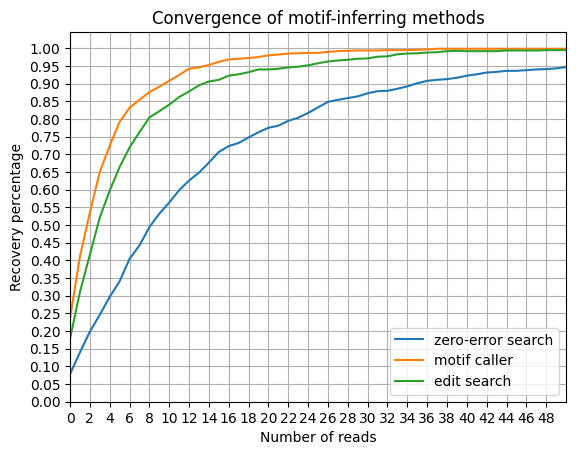

In [32]:
plt.plot(avg_search, label='zero-error search')
plt.plot(avg_caller, label='motif caller')
plt.plot(avg_edit, label='edit search')
plt.grid()
plt.yticks(np.arange(0, 1.01, 0.05))
plt.xticks(np.arange(0, 50, 2))
plt.xlim(0, 50)
plt.xlabel("Number of reads")
plt.ylabel("Recovery percentage")
plt.title("Convergence of motif-inferring methods")
plt.legend()

## Edit-distance search

In [1]:
import pandas as pd

df = pd.read_pickle(r"C:\Users\Parv\Doc\HelixWorks\Basecalling\code\motifcaller\data\empirical\full_datasets\master_test.pkl")

In [3]:

with open(r"C:\Users\Parv\Doc\HelixWorks\Basecalling\code\motifcaller\data\empirical\edit_distance_motif_search\res-loose-chain.txt", 'r') as f:
    lines = f.readlines()

In [17]:
read_ids = []
positions = []
orientations = []
motifs_found = []

for i in lines:
    split_i = i.split()
    read_ids.append(split_i[0][3:])
    orientations.append(split_i[1])
    positions.append(split_i[2][4:].split('-'))
    motifs_found.append(split_i[4][8:].split('->'))
    

In [24]:
motifs_found_ = [[int(j[1]) for j in i if not j == 'fake' and j.startswith('m')] for i in motifs_found ]

In [31]:
edit_distance_df = pd.DataFrame({'read_id': read_ids, 'positions': positions, 'orientations': orientations, 'edit_motif_seq': motifs_found_})

In [40]:
edit_distance_df.to_pickle(r"C:\Users\Parv\Doc\HelixWorks\Basecalling\code\motifcaller\data\empirical\edit_distance_motif_search.pkl")

In [33]:
merged_df = pd.merge(df, edit_distance_df, on='read_id')

In [36]:
df.head()

,read_id,ONT_Barcode,HW_Address,orientation,start_end,library_motif,squiggle,motif_seq,strand,payload_motifs_found,payload_seq
0,009d2a08-23ad-4898-972e-f60846a3c88e,9,barcode_external01_internal01,+|+|+,152-201|353-402|453-502,ltm8_2x1|ltm8_8x3|ltm8_10x3,"[510, 482, 479, 471, 451, 468, 491, 494, 489, ...","[10, 1, 10, 16, 3, 16, 18, 3, 18]",+,3,"[[1, 2, 4, 5], [2, 4, 5, 6], [2, 5, 6, 8], [2,..."
1,00a90609-14cf-4fae-a960-de328215482c,9,barcode_external01_internal01,+|+|+,71-120|121-170|318-367,ltm8_5x1|ltm8_6x1|ltm8_10x6,"[662, 547, 547, 551, 538, 535, 542, 557, 527, ...","[13, 1, 13, 14, 1, 14, 18, 6, 18]",+,3,"[[1, 2, 4, 5], [2, 4, 5, 6], [2, 5, 6, 8], [2,..."
2,01541240-8c0e-417e-b9fd-3f316e068029,9,barcode_external01_internal01,+|+|+|+|+|+,107-156|207-256|358-407|408-457|458-507|508-557,ltm8_1x1|ltm8_3x2|ltm8_5x6|ltm8_6x7|ltm8_7x1|l...,"[444, 508, 511, 502, 509, 509, 474, 459, 488, ...","[9, 1, 9, 11, 2, 11, 13, 6, 13, 14, 7, 14, 15,...",+,6,"[[1, 2, 4, 5], [2, 4, 5, 6], [2, 5, 6, 8], [2,..."
3,02c08936-e93b-411d-973f-4c66775f96f2,9,barcode_external01_internal01,+,451-500,ltm8_9x5,"[490, 501, 499, 513, 500, 481, 506, 503, 519, ...","[17, 5, 17]",+,1,"[[1, 2, 4, 5], [2, 4, 5, 6], [2, 5, 6, 8], [2,..."
4,05ec1729-df38-4112-aa48-b0bc81ec9a08,9,barcode_external01_internal01,+|+|+,84-133|184-233|234-283,ltm8_4x8|ltm8_6x1|ltm8_7x1,"[453, 512, 534, 501, 483, 507, 488, 499, 498, ...","[12, 8, 12, 14, 1, 14, 15, 1, 15]",+,3,"[[1, 2, 4, 5], [2, 4, 5, 6], [2, 5, 6, 8], [2,..."


In [55]:
from transcript_sorting import sort_transcript

In [ ]:
for i, row in merged_df.iterrows():
    payload_seq = row['payload_seq']
    search_seq = row['motif_seq']
    edit_seq = row['edit_motif_seq']
    orientation = row['orientation']
    
    if len(edit_seq) <= 8:
        print(evaluate_prediction([[i] for i in edit_seq], payload_seq))
        print(evaluate_prediction(sort_transcript(search_seq), payload_seq))
        print()




(4, 3)
(2, 0)

(3, 3)
(1, 2)

(2, 0)
(5, 0)

(3, 4)
(0, 1)

(2, 4)
(1, 2)

(3, 1)
(1, 0)

(7, 1)
(2, 0)

(4, 3)
(3, 0)

(5, 2)
(2, 1)

(2, 4)
(1, 1)

(5, 3)
(2, 0)

(5, 1)
(3, 0)

(1, 3)
(1, 1)

(6, 0)
(4, 0)

(3, 5)
(2, 0)

(5, 3)
(4, 0)

(1, 3)
(1, 0)

(5, 3)
(0, 0)

(1, 5)
(0, 1)

(3, 3)
(2, 0)

(0, 4)
(1, 1)

(7, 1)
(2, 0)

(4, 2)
(0, 0)

(1, 3)
(0, 1)

(5, 3)
(1, 0)

(5, 3)
(2, 0)

(3, 5)
(1, 0)

(2, 4)
(1, 0)

(5, 3)
(2, 0)

(2, 4)
(0, 1)

(5, 2)
(1, 0)

(2, 3)
(1, 1)

(3, 2)
(1, 0)

(1, 3)
(1, 1)

(2, 5)
(0, 1)

(3, 2)
(1, 0)

(4, 4)
(0, 0)

(1, 4)
(0, 2)

(4, 3)
(2, 0)

(4, 1)
(0, 1)

(3, 4)
(3, 0)

(3, 3)
(1, 0)

(3, 3)
(1, 0)

(2, 6)
(1, 4)

(3, 1)
(0, 3)

(1, 3)
(1, 0)

(3, 3)
(1, 1)

(1, 7)
(1, 4)

(1, 5)
(2, 1)

(1, 6)
(1, 1)

(3, 3)
(0, 1)

(3, 5)
(2, 0)

(4, 3)
(1, 0)

(3, 3)
(3, 0)

(5, 3)
(4, 0)

(1, 6)
(0, 0)

(4, 3)
(4, 0)

(3, 5)
(1, 0)

(4, 3)
(1, 0)

(2, 3)
(1, 0)

(4, 2)
(3, 0)

(4, 4)
(1, 0)

(6, 2)
(4, 0)

(2, 3)
(0, 1)

(3, 5)
(5, 0)

(4, 3)
(2, 0)

(1, 2)
(0,